# Dissertation Code - B151410

## Synthetic Data Generation

The object of section of the program is to take as inputs the UK Time Use Survey from 2014-2015 and use two a deep learning algorithm to create a synthetic version of the data. This synthetic data will share all the properties of the original set, but will be slightly modified. In effect, this simulates moving the original data forward in time with an amount of noise. This process is broadly reflective of the newest papers in machine learning approaches to population dynamics. 

This process is summarized and evaluated in more detail in Section 4.1 - 'Synthetic Data Generation' within my dissertation.

### Data Preparation

In [30]:
''' before actually generating the synthetic data, we have to build out the dataset by combining the micro-timeuse data with 
existing patterns in health data'''

# relevant imports and data
import pandas as pd
import random
df1 = pd.read_excel("C:\\Users\\s1969938\\Downloads\\Real_Data_Cleaned.xlsx", index_col=0)


# using pre-defined prevalence rates to determine how many individuals will have each disease - effectively parameterization
obs = 934
cancer = 0.0377*obs
CKD = 0.0501*obs
CLiD  = 0.00126*obs
CLuD = 0.093*obs
CF = 0.0004*obs
dementia = 0.0091*obs
diabetes = 0.068*obs
disability = 0.177*obs
heart = 0.2295*obs
HIV = 0.0013*obs
mental_health = 0.1276*obs
obesity= 0.1014*obs
pregnancy = 0.011377*obs
sickle_cell = 0.0005*obs
smoking = 0.126*obs
transplant = 0.00007*obs
stroke = 0.0233*obs
substance = 0.004*obs

# creating a Python dictionary to hold the amount of individuals who should be allocated disease
num_random_vars = {'Cancer': cancer, 
                   'Chronic kidney disease': CKD,
                   'Chronic liver disease': CLiD, 
                   'Chronic lung disease': CLuD, 
                   'Cystic fibrosis': CF,
                   'Dementia': dementia, 
                   'Diabetes': diabetes, 
                   'Disability': disability, 
                   'Heart conditions': heart, 
                   'HIV': HIV,
                   'Mental health': mental_health, 
                   'Obesity': obesity, 
                   'Pregnancy': pregnancy,
                   'Sickle cell disease': sickle_cell,
                   'Smoking': smoking, 
                   'Solid organ or blood stem cell transplant': transplant, 
                   'Stroke': stroke, 
                   'Substance use disorder': substance}

# looping through the dictionary to sample correct number of random numbers, then add disease for individuals at those random numbers
for column_name, num_vars in num_random_vars.items():
    num_vars = int(num_vars)
    random_numbers = random.sample(range(0, len(df1)), num_vars)
    df1.loc[random_numbers, column_name] = 1

# to test that values were replaced
if df1['Cancer'].nunique()==1:
    print("Process failed, all values in the column are the same")
else:
    print("Data is prepped, all values in the column are NOT the same")

Data is prepped, all values in the column are NOT the same


### Data Generation Process

In [31]:
# importing relevant data generation packages
import sdv as sdv

# many of the values in the survey have responses that are 'Item not applicable', 
# to make it easier for the neural net to build estimations, these N/A values will be replaced by 0
df1.replace(to_replace=r'^Item not applicable', value=0, regex=True)

,Wrking,Stat,dsic,HrWkUS,DVHsize,Educ,LeisNum1,LeisNum2,LeisNum5,LeisNum6,...,Heart conditions,HIV,Mental health,Obesity,Pregnancy,Sickle cell disease,Smoking,Solid organ or blood stem cell transplant,Stroke,Substance use disorder
Number,,,,,,,,,,,,,,,,,,,,,
0,No,Self-employed,Manufacturing,0,2,No,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,No,Employee,Manufacturing,0,2,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Yes,Employee,"Public admin, education and health",14,2,No,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
3,Yes,Employee,"Public admin, education and health",40,2,No,0,0,2,0,...,1,0,0,1,0,0,0,0,0,0
4,Yes,Employee,Other services,15,3,Yes,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
930,Yes,Self-employed,"Agriculture, forestry and fishing",0,1,No,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
931,No,Employee,"Public admin, education and health",0,2,No,1,0,3,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# importing relevant package to create metadata attributes
from sdv.metadata import SingleTableMetadata

# defining metadata, importing results from table, and adding a dictionary so that metadata results are easily accessible
metadata=SingleTableMetadata()
metadata.detect_from_dataframe(data=df1)
python_dict = metadata.to_dict() # note that this dictionary is nested, the key for 'column' is another dictionary with all the column results

# the validate command ensures that the key is set properly and that the each column's variable is appropriately categorized
metadata.validate()

In [33]:
# import the actual synthesizer from the OpenSource library
from sdv.single_table import CTGANSynthesizer

'''
# in calling the synthesizer, three parameters are given:
1) metadata - the data will be estimated based on established parameters from the data (same number of categorical/numerical/etc. variables)
2) there will be 1000 epochs, which means that the algorithm will be run through 1000 iterations, this is above-average for a CTGAN and should yield strong samples
3) that the generator and discriminator loss will be reported manually for each iteration, these loss functions give an estimation of the model's success
where lower numbers indicate better training'''

synthesizer = CTGANSynthesizer(metadata, epochs=1000, verbose=True)
synthesizer.fit(df1)

Epoch 1, Loss G:  2.2957,Loss D: -0.0174
Epoch 2, Loss G:  2.2512,Loss D: -0.0382
Epoch 3, Loss G:  2.2491,Loss D: -0.1302
Epoch 4, Loss G:  2.1760,Loss D: -0.2052
Epoch 5, Loss G:  2.1690,Loss D: -0.3066
Epoch 6, Loss G:  2.1541,Loss D: -0.3896
Epoch 7, Loss G:  2.2223,Loss D: -0.4876
Epoch 8, Loss G:  2.1745,Loss D: -0.5854
Epoch 9, Loss G:  2.2188,Loss D: -0.7266
Epoch 10, Loss G:  2.2457,Loss D: -0.8114
Epoch 11, Loss G:  2.2509,Loss D: -0.9613
Epoch 12, Loss G:  2.2591,Loss D: -1.1444
Epoch 13, Loss G:  2.2920,Loss D: -1.3652
Epoch 14, Loss G:  2.3698,Loss D: -1.3555
Epoch 15, Loss G:  2.3592,Loss D: -1.5414
Epoch 16, Loss G:  2.4144,Loss D: -1.6616
Epoch 17, Loss G:  2.4225,Loss D: -1.8647
Epoch 18, Loss G:  2.2378,Loss D: -1.7284
Epoch 19, Loss G:  2.3142,Loss D: -1.7485
Epoch 20, Loss G:  2.3212,Loss D: -1.6783
Epoch 21, Loss G:  2.2082,Loss D: -1.6536
Epoch 22, Loss G:  2.2037,Loss D: -1.6395
Epoch 23, Loss G:  2.1472,Loss D: -1.5843
Epoch 24, Loss G:  2.1843,Loss D: -1.6476
E

Epoch 195, Loss G:  0.0863,Loss D:  0.3300
Epoch 196, Loss G:  0.2766,Loss D:  0.3505
Epoch 197, Loss G:  0.2937,Loss D:  0.3020
Epoch 198, Loss G:  0.0793,Loss D:  0.2472
Epoch 199, Loss G:  0.0609,Loss D:  0.4255
Epoch 200, Loss G:  0.2778,Loss D:  0.2008
Epoch 201, Loss G:  0.3097,Loss D:  0.1819
Epoch 202, Loss G:  0.1055,Loss D: -0.0407
Epoch 203, Loss G:  0.3519,Loss D: -0.0254
Epoch 204, Loss G:  0.4303,Loss D:  0.1900
Epoch 205, Loss G:  0.5341,Loss D:  0.0171
Epoch 206, Loss G:  0.5609,Loss D: -0.2297
Epoch 207, Loss G:  0.6984,Loss D:  0.0363
Epoch 208, Loss G:  0.7470,Loss D: -0.3304
Epoch 209, Loss G:  0.6312,Loss D: -0.1317
Epoch 210, Loss G:  0.7551,Loss D:  0.0567
Epoch 211, Loss G:  0.8282,Loss D: -0.1553
Epoch 212, Loss G:  0.8358,Loss D: -0.3848
Epoch 213, Loss G:  0.6687,Loss D: -0.0123
Epoch 214, Loss G:  0.2902,Loss D: -0.0845
Epoch 215, Loss G:  0.2083,Loss D:  0.2747
Epoch 216, Loss G:  0.2819,Loss D: -0.0067
Epoch 217, Loss G:  0.3287,Loss D:  0.1707
Epoch 218, 

Epoch 386, Loss G: -0.4431,Loss D: -0.0689
Epoch 387, Loss G:  0.0044,Loss D:  0.1315
Epoch 388, Loss G: -0.4628,Loss D: -0.0064
Epoch 389, Loss G: -0.2250,Loss D: -0.1711
Epoch 390, Loss G: -0.2375,Loss D:  0.0645
Epoch 391, Loss G: -0.2532,Loss D: -0.0721
Epoch 392, Loss G: -0.5271,Loss D: -0.3265
Epoch 393, Loss G: -0.3463,Loss D: -0.0798
Epoch 394, Loss G: -0.2523,Loss D: -0.2193
Epoch 395, Loss G: -0.3899,Loss D:  0.1573
Epoch 396, Loss G: -0.2613,Loss D:  0.1385
Epoch 397, Loss G: -0.2432,Loss D:  0.0441
Epoch 398, Loss G: -0.5060,Loss D:  0.0121
Epoch 399, Loss G: -0.5982,Loss D:  0.2069
Epoch 400, Loss G: -0.4420,Loss D:  0.3101
Epoch 401, Loss G: -0.4126,Loss D:  0.0626
Epoch 402, Loss G: -0.3633,Loss D:  0.4747
Epoch 403, Loss G: -0.2638,Loss D:  0.0986
Epoch 404, Loss G: -0.4248,Loss D:  0.2448
Epoch 405, Loss G: -0.2050,Loss D: -0.0148
Epoch 406, Loss G: -0.5853,Loss D:  0.2567
Epoch 407, Loss G: -0.0943,Loss D:  0.1248
Epoch 408, Loss G: -0.2341,Loss D:  0.1490
Epoch 409, 

Epoch 577, Loss G: -1.3516,Loss D:  0.1682
Epoch 578, Loss G: -1.2719,Loss D:  0.2215
Epoch 579, Loss G: -0.9382,Loss D: -0.1546
Epoch 580, Loss G: -1.1383,Loss D: -0.1311
Epoch 581, Loss G: -1.0389,Loss D:  0.3956
Epoch 582, Loss G: -1.2578,Loss D: -0.0138
Epoch 583, Loss G: -1.1551,Loss D:  0.4035
Epoch 584, Loss G: -1.1014,Loss D: -0.0138
Epoch 585, Loss G: -1.2094,Loss D: -0.1496
Epoch 586, Loss G: -1.1313,Loss D:  0.5452
Epoch 587, Loss G: -1.1641,Loss D:  0.2124
Epoch 588, Loss G: -1.0823,Loss D: -0.3669
Epoch 589, Loss G: -0.9723,Loss D: -0.5596
Epoch 590, Loss G: -0.9676,Loss D:  0.0965
Epoch 591, Loss G: -0.9513,Loss D: -0.1677
Epoch 592, Loss G: -1.0543,Loss D:  0.0689
Epoch 593, Loss G: -0.6379,Loss D: -0.1861
Epoch 594, Loss G: -1.0974,Loss D: -0.4057
Epoch 595, Loss G: -1.0824,Loss D: -0.0485
Epoch 596, Loss G: -0.7669,Loss D: -0.1475
Epoch 597, Loss G: -0.9097,Loss D: -0.0410
Epoch 598, Loss G: -1.0181,Loss D:  0.0778
Epoch 599, Loss G: -1.1542,Loss D: -0.1500
Epoch 600, 

Epoch 768, Loss G: -1.6746,Loss D: -0.0844
Epoch 769, Loss G: -1.9438,Loss D: -0.3013
Epoch 770, Loss G: -1.9816,Loss D:  0.0205
Epoch 771, Loss G: -2.0038,Loss D: -0.0685
Epoch 772, Loss G: -1.7274,Loss D: -0.3202
Epoch 773, Loss G: -1.7841,Loss D: -0.1922
Epoch 774, Loss G: -1.5525,Loss D:  0.2101
Epoch 775, Loss G: -1.5116,Loss D:  0.4038
Epoch 776, Loss G: -1.9123,Loss D:  0.0377
Epoch 777, Loss G: -1.5435,Loss D:  0.0795
Epoch 778, Loss G: -1.7912,Loss D:  0.1817
Epoch 779, Loss G: -1.5831,Loss D:  0.0438
Epoch 780, Loss G: -1.8114,Loss D:  0.1741
Epoch 781, Loss G: -1.6072,Loss D:  0.3928
Epoch 782, Loss G: -1.6688,Loss D: -0.1476
Epoch 783, Loss G: -1.5583,Loss D: -0.2535
Epoch 784, Loss G: -1.6547,Loss D: -0.0275
Epoch 785, Loss G: -1.5500,Loss D:  0.3837
Epoch 786, Loss G: -1.6370,Loss D: -0.3618
Epoch 787, Loss G: -1.4424,Loss D:  0.0282
Epoch 788, Loss G: -1.2978,Loss D: -0.1977
Epoch 789, Loss G: -1.2488,Loss D:  0.1283
Epoch 790, Loss G: -1.3055,Loss D:  0.2991
Epoch 791, 

Epoch 959, Loss G: -1.5351,Loss D:  0.5029
Epoch 960, Loss G: -1.3309,Loss D:  0.2920
Epoch 961, Loss G: -1.6991,Loss D: -0.6722
Epoch 962, Loss G: -1.7423,Loss D: -0.0984
Epoch 963, Loss G: -1.5776,Loss D: -0.1347
Epoch 964, Loss G: -1.1113,Loss D: -0.1473
Epoch 965, Loss G: -1.2791,Loss D: -0.2524
Epoch 966, Loss G: -1.4007,Loss D: -0.2605
Epoch 967, Loss G: -1.3676,Loss D: -0.3043
Epoch 968, Loss G: -1.3880,Loss D: -0.2561
Epoch 969, Loss G: -1.2741,Loss D: -0.2497
Epoch 970, Loss G: -1.2250,Loss D: -0.7118
Epoch 971, Loss G: -1.6548,Loss D: -0.0753
Epoch 972, Loss G: -1.6876,Loss D: -0.3921
Epoch 973, Loss G: -1.4472,Loss D: -0.5828
Epoch 974, Loss G: -1.4351,Loss D:  0.2735
Epoch 975, Loss G: -1.3454,Loss D: -0.3418
Epoch 976, Loss G: -1.4436,Loss D: -0.2119
Epoch 977, Loss G: -1.6866,Loss D: -0.2892
Epoch 978, Loss G: -1.4016,Loss D: -0.3389
Epoch 979, Loss G: -1.8673,Loss D:  0.1217
Epoch 980, Loss G: -1.9171,Loss D:  0.4298
Epoch 981, Loss G: -1.8388,Loss D: -0.3354
Epoch 982, 

ContextualVersionConflict: (cloudpickle 2.0.0 (c:\anaconda\lib\site-packages), Requirement.parse('cloudpickle<3.0,>=2.1.0'), {'sdv'})

Please note that the above error refers to an IDE problem with the way that I downloaded the sdv library, as I was on a university computer that had likely had earlier package downloads which conflicted with the sdv. This has no impact on the synthesizer's accuracy, quality, or speed.

In [34]:
'''
now that we have fit a synthesizer that will accurately synthesize data based on the real tabular data, we can take samples.
since the performance of the synthesizer was strong based on the generator/discriminator loss patterns, we can expect solid data quality
at an extremely high resolution - which is a central goal of this paper
'''

# Using the trained synthesizer to sample 1000 individuals that should share similar characteristics, exported to csv file for next stage
synthetic_data = synthesizer.sample(num_rows=1000, output_file_path="C:\\Users\\s1969938\\Downloads\\synthetic_test.csv")

# print statement to confirm sampling
print('done')

done


### Evaluative Metrics

In [36]:
# previous code used the synthesizer to build a csv file so that I could use it in future stages
# however, to evaluate the synthetically generated data, it must be put back into a dataframe
df2 = pd.read_csv("C:\\Users\\s1969938\\Downloads\\synthetic_test.csv", index_col=0)

# using pre-defined library to build a quality_report showing how close data is to real - should output a quality report will all relevant metrics
from sdv.evaluation.single_table import evaluate_quality
quality_report = evaluate_quality(real_data=df1, synthetic_data=df2, metadata=metadata)

C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\reports\utils.py:661: UserWarning: Unexpected values ("40", "46", "18", "37", "50" + more) in column "HrWkUS"
  warnings.warn(warning_format.format(values=values, column=column))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\reports\utils.py:661: UserWarning: Unexpected values ("1", "2", "4", "3") in column "LeisNum1"
  warnings.warn(warning_format.format(values=values, column=column))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\reports\utils.py:661: UserWarning: Unexpected values ("1", "2", "5", "4", "3") in column "LeisNum2"
  warnings.warn(warning_format.format(values=values, column=column))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\reports\utils.py:661: UserWarning: Unexpected values ("6", "1", "3", "2", "4" + more) in column "LeisNum5"
  warnings.warn(warning_format.format(values=values, column=column))
C:\Users\s196993

C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:78: ConstantInputWarning: The real data in column 'Solid organ or blood stem cell transplant' contains a constant value. Correlation is undefined for constant data.
  warnings.warn(ConstantInputWarning(msg))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:78: ConstantInputWarning: The synthetic data in column 'Solid organ or blood stem cell transplant' contains a constant value. Correlation is undefined for constant data.
  warnings.warn(ConstantInputWarning(msg))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:78: ConstantInputWarning: The synthetic data in column 'Substance use disorder' contains a constant value. Correlation is undefined for constant data.
  warnings.warn(ConstantInputWarning(msg))
C:\Users\s

C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:78: ConstantInputWarning: The synthetic data in column 'Cystic fibrosis' contains a constant value. Correlation is undefined for constant data.
  warnings.warn(ConstantInputWarning(msg))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:78: ConstantInputWarning: The real data in columns 'Cystic fibrosis, Solid organ or blood stem cell transplant' contain a constant value. Correlation is undefined for constant data.
  warnings.warn(ConstantInputWarning(msg))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:78: ConstantInputWarning: The synthetic data in columns 'Cystic fibrosis, Solid organ or blood stem cell transplant' contain a constant value. Correlation is undefined for constant data.
  warnings.warn(ConstantIn

C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:78: ConstantInputWarning: The synthetic data in column 'Substance use disorder' contains a constant value. Correlation is undefined for constant data.
  warnings.warn(ConstantInputWarning(msg))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:78: ConstantInputWarning: The real data in column 'Sickle cell disease' contains a constant value. Correlation is undefined for constant data.
  warnings.warn(ConstantInputWarning(msg))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\column_pairs\statistical\correlation_similarity.py:78: ConstantInputWarning: The synthetic data in column 'Sickle cell disease' contains a constant value. Correlation is undefined for constant data.
  warnings.warn(ConstantInputWarning(msg))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site


Overall Quality Score: 86.29%

Properties:
Column Shapes: 86.68%
Column Pair Trends: 85.9%


In [37]:
# supplementing quality report with diagnostic function
from sdv.evaluation.single_table import run_diagnostic
diagnostic_report = run_diagnostic(real_data=df1, synthetic_data=df2, metadata=metadata)

C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\reports\utils.py:661: UserWarning: Unexpected values ("40", "46", "18", "37", "50" + more) in column "HrWkUS"
  warnings.warn(warning_format.format(values=values, column=column))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\reports\utils.py:661: UserWarning: Unexpected values ("1", "2", "4", "3") in column "LeisNum1"
  warnings.warn(warning_format.format(values=values, column=column))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\reports\utils.py:661: UserWarning: Unexpected values ("1", "2", "5", "4", "3") in column "LeisNum2"
  warnings.warn(warning_format.format(values=values, column=column))
C:\Users\s1969938\AppData\Roaming\Python\Python39\site-packages\sdmetrics\reports\utils.py:661: UserWarning: Unexpected values ("6", "1", "3", "2", "4" + more) in column "LeisNum5"
  warnings.warn(warning_format.format(values=values, column=column))
C:\Users\s196993


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data
! The synthetic data is missing more than 10% of the categories present in the real data


Please note again that the runtime warnings are because of the format of the data, many of the columns have mixed categorical and constant values, as a result the computer throws run-time warnings, these are not errors and do not create questions with the quality report.

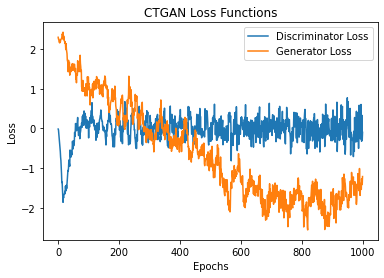

In [45]:
# plotting discriminator and generator loss functions 

# I previously put the loss function values into an xlsx file, this brings them back for graphing
loss = pd.read_excel("C:\\Users\\s1969938\\Downloads\\Loss.xlsx")

discriminator_losses = list(loss['Discriminator'])
generator_losses = list(loss['Generator'])

# import relevant libraries
import matplotlib.pyplot as plt

plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CTGAN Loss Functions')
plt.show()

ALL results will be discussed in Section 6, in 6.1 - Synthetic Data Generation or 6.4 - Validity